In [7]:
%matplotlib inline
import time 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from vivarium.framework.event import listens_for, emits
from vivarium.framework.values import modifies_value, produces_value
from vivarium.framework.population import uses_columns
import vivarium.test_util as vtu

!date

Wed Feb 14 15:36:24 PST 2018


# Simple Disease Model

In [8]:
n_simulants = 10*1000
n_days = 365*10
t_start = pd.Timestamp('1990-01-01')

In [9]:
class SimpleIntervention:
    intervention_group = 'age >= 25 and alive == "alive"'

    def setup(self, builder):
        self.clock = builder.clock()
        self.reset()

    @listens_for('time_step')
    @uses_columns(['age', 'alive'], intervention_group)
    def track_cost(self, event):
        if event.time.year >= 1995:
            time_step = event.step_size
            # FIXME: charge full price once per year?
            self.cumulative_cost += 2.0 * len(event.index) * (time_step / pd.Timedelta(days=365))

    @modifies_value('mortality_rate')
    @uses_columns(['age'], intervention_group)
    def mortality_rates(self, index, rates, population_view):
        if self.clock().year >= 1995:
            pop = population_view.get(index)
            rates.loc[pop.index] *= 0.5
        return rates

    def reset(self):
        self.cumulative_cost = 0

    @listens_for('simulation_end', priority=0)
    def dump_metrics(self, event):
        print('Cost:', self.cumulative_cost)

        
class SimpleMortality:
    configuration_defaults = {
            'hello_world': {'mortality_rate': 0.01}
    }

    def setup(self, builder):
        self.config = builder.configuration.hello_world
        self.mortality_rate = builder.rate('mortality_rate')

    @produces_value('mortality_rate')
    def base_mortality_rate(self, index):
        return pd.Series(self.config.mortality_rate, index=index)

    @listens_for('time_step')
    @emits('deaths')
    @uses_columns(['alive'], "alive == 'alive'")
    def handler(self, event, death_emitter):
        effective_rate = self.mortality_rate(event.index)
        effective_probability = 1-np.exp(-effective_rate)
        draw = np.random.random(size=len(event.index))
        affected_simulants = draw < effective_probability
        event.population_view.update(pd.Series('dead', index=event.index[affected_simulants]).astype(
                                  pd.api.types.CategoricalDtype(
                                      categories=['alive', 'dead', 'untracked'], ordered=False)))
        death_emitter(event.split(affected_simulants.index))

        
def build_life_table():
    max_age = 110
    max_expectency = 90
    min_expectency = 1.5
    
    ages = np.arange(0, max_age, 0.01)
    life_expectency = np.linspace(max_expectency, min_expectency, len(ages))
    
    return pd.DataFrame({'age': ages,
                         'life_expectency': life_expectency})


class SimpleMetrics:
    def setup(self, builder):
        self.reset()
        self.life_table = builder.lookup(build_life_table(),
                                         key_columns=(), parameter_columns=('age',))

    @listens_for('deaths')
    def count_deaths_and_ylls(self, event):
        self.deaths += len(event.index)

        t = self.life_table(event.index)
        self.ylls += t.sum()

    def reset(self):
        self.start_time = time.time()
        self.deaths = 0
        self.ylls = 0

    def run_time(self):
        return time.time() - self.start_time

    @listens_for('simulation_end', priority=0)
    def dump_metrics(self, event):
        print('\nWith intervention:')
        print('Deaths:', self.deaths)
        print('YLLs:', self.ylls)
        print('Run time:', self.run_time())

In [10]:
components = [vtu.TestPopulation(), vtu.age_simulants,
              SimpleMortality(), SimpleIntervention(), SimpleMetrics()]

In [11]:
simulation = vtu.setup_simulation(components, population_size=n_simulants, start=t_start)
metrics = simulation.values.get_value('metrics')

In [12]:
simulation.population.population.head()

,location,entrance_time,age,alive,sex,exit_time
0,180,1990-01-01,76.932171,alive,Female,NaT
1,180,1990-01-01,2.611212,alive,Male,NaT
2,180,1990-01-01,65.258061,alive,Male,NaT
3,180,1990-01-01,20.624341,alive,Male,NaT
4,180,1990-01-01,35.122283,alive,Male,NaT


In [13]:
simulation.population.population.dtypes

location                  int64
entrance_time    datetime64[ns]
age                     float64
alive                  category
sex                      object
exit_time        datetime64[ns]
dtype: object

In [14]:
simulation.population.population.alive.cat.categories

Index(['alive', 'dead', 'untracked'], dtype='object')

In [15]:
pd.Series()

Series([], dtype: float64)

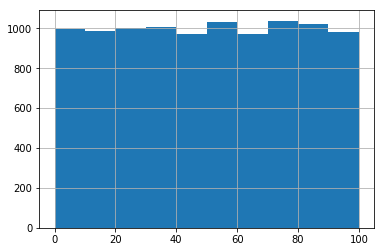

In [16]:
simulation.population.population.age.hist()

In [17]:
vtu.pump_simulation(simulation, duration=pd.Timedelta(days=n_days))

VBox(children=(HTML(value=''), IntProgress(value=0, max=3650)))

Cost: 77444.02739726077

With intervention:
Deaths: 34890669
YLLs: 1591812988.6724179
Run time: 190.9860978126526


3650

In [ ]:
simulation.population.population.age.hist()

In [ ]:
simulation.population.population.exit_time.describe()

In [ ]:
df = simulation.population.population
df.alive.value_counts()

In [ ]:
cdr = (df.alive != 'alive').sum() / (n_days/365*len(df))
print('CDR = {:.1f} / 1000'.format(1000*cdr))